In [1]:
%reload_ext autoreload
%autoreload 2

# %matplotlib qt

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import sklearn
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [12]:
@torch.no_grad()
def cvPCA(X1, X2):
    """X1, X2 are both (dimensions x samples)"""
    D, B = X1.shape
    assert X2.shape == (D, B), "shape of X1 and X2 is not the same"
    _, u = utils.smart_pca(X1)
    
    cproj0 = X1.T @ u
    cproj1 = X2.T @ u
    ss = (cproj0 * cproj1).mean(axis=0)
    return ss

def get_num_components(nc, shape):
    return nc if nc is not None else min(shape)

@torch.no_grad()
def shuff_cvPCA(X1, X2, nshuff=5, cvmethod=cvPCA):
    """X1, X2 are both (dimensions x samples)"""
    D, B = X1.shape
    assert X2.shape == (D, B), "shape of X1 and X2 is not the same"
    nc = get_num_components(None, (D, B))
    ss=torch.zeros((nshuff,nc))
    X = torch.stack((X1, X2))
    for k in range(nshuff):
        iflip = 1*(torch.rand(B) > 0.5)
        X1c = torch.gather(X, 0, iflip.view(1, 1, -1).expand(1, D, -1)).squeeze(0)
        X2c = torch.gather(X, 0, -(iflip-1).view(1, 1, -1).expand(1, D, -1)).squeeze(0)
        ss[k]=cvmethod(X1c, X2c)
    return ss

In [2]:
model_name = 'MLP'
dataset_name = 'MNIST'

# hidden_widths = [400, 400, 400]
net = get_model(model_name, build=True, dataset=dataset_name, dropout=0.0, ignore_flag=False)
net.to(DEVICE)

loader_parameters = dict(
    shuffle=True,
)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, loader_parameters=loader_parameters, device=DEVICE)

optimizer = torch.optim.Adam(net.parameters())

parameters = dict(
    num_epochs=20,
    alignment=False,
    compare_expected=False,
    frequency=5,
    delta_alignment=False,
)
results = train.train([net], [optimizer], dataset, **parameters)

training epoch: 100%|██████████| 20/20 [01:04<00:00,  3.25s/it]


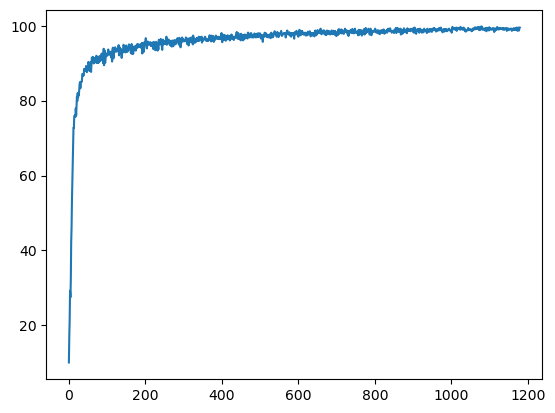

In [7]:
plt.plot(results['accuracy'])
plt.show()

In [3]:
images = []
labels = []
for batch in tqdm(dataset.train_loader):
    cimages, clabels = dataset.unwrap_batch(batch)
    images.append(cimages)
    labels.append(clabels)
images = torch.concatenate(images, dim=0)
images = images.view(images.size(0), -1)
# images = images - images.mean(dim=0)
labels = torch.concatenate(labels, dim=0)
print(images.shape, labels.shape)

# get stacked indices to the elements of each class
classes = torch.unique(labels)
num_classes = len(classes)
idx_to_class = [torch.where(labels == ii)[0] for ii in classes]
num_per_class = [len(idx) for idx in idx_to_class]
min_per_class = min(num_per_class)
if any([npc > min_per_class for npc in num_per_class]):
    idx_to_class = [idx[:min_per_class] for idx in idx_to_class]

# use single tensor for fast indexing
idx_to_class = torch.stack(idx_to_class).unsqueeze(2)

# (classes, images, image_dimension)
images_by_class = torch.gather(images.unsqueeze(0).expand(num_classes, -1, -1), 1, idx_to_class.expand(-1, -1, images.size(1)))

100%|██████████| 59/59 [00:03<00:00, 18.35it/s]


torch.Size([60000, 784]) torch.Size([60000])


In [10]:
# Make a CV Dataset of inputs to each layer for each class
inputs_to_layers = net.get_layer_inputs(images, precomputed=False)
inputs_to_layers = net._preprocess_inputs(inputs_to_layers)
inputs_by_class = [torch.gather(inputs.unsqueeze(0).expand(num_classes, -1, -1), 1, idx_to_class.expand(-1, -1, inputs.size(1))) 
                   for inputs in inputs_to_layers]

print([i.shape for i in inputs_to_layers])
print([i.shape for i in inputs_by_class])
print(images_by_class.shape)

[torch.Size([60000, 784]), torch.Size([60000, 100]), torch.Size([60000, 100]), torch.Size([60000, 50])]
[torch.Size([10, 5421, 784]), torch.Size([10, 5421, 100]), torch.Size([10, 5421, 100]), torch.Size([10, 5421, 50])]
torch.Size([10, 5421, 784])


In [11]:
# make a CV dataset
num_per_class = images_by_class.size(1)
random_sort = torch.randperm(num_per_class)
train_examples = random_sort[:num_per_class//2]
test_examples = random_sort[num_per_class//2:num_per_class//2+num_per_class//2]
inputs_train = [inputs[:, train_examples].reshape(-1, inputs.size(2)) for inputs in inputs_by_class]
inputs_test = [inputs[:, test_examples].reshape(-1, inputs.size(2)) for inputs in inputs_by_class]

# measure eigenfeatures
w, v = utils.named_transpose([utils.smart_pca(inputs.T) for inputs in inputs_to_layers])
w = [(w / torch.sum(w)).cpu() for w in w]

# cvPCA method
cc = [utils.shuff_cvPCA(itrain.T.cpu(), itest.T.cpu(), nshuff=5).cpu() for itrain, itest in zip(inputs_train, inputs_test)]
cc = [cc.mean(dim=0) for cc in cc]
cc = [cc / torch.sum(cc) for cc in cc]

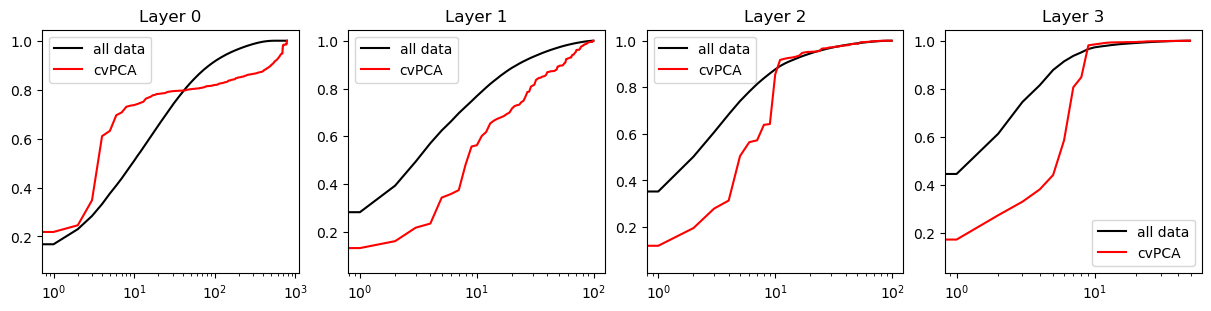

In [18]:
cumsum = True

num_layers = len(w)
figdim = 3
fig, ax = plt.subplots(1, num_layers, figsize=(num_layers*figdim, figdim), layout='constrained')
for layer in range(num_layers):
    if cumsum:
        ax[layer].plot(range(len(w[layer])), torch.cumsum(w[layer], 0), c='k', label='all data')
        ax[layer].plot(range(len(w[layer])), torch.cumsum(cc[layer], 0), c='r', label='cvPCA')
    else:
        ax[layer].plot(range(len(w[layer])), w[layer], c='k', label='all data')
        ax[layer].plot(range(len(w[layer])), cc[layer], c='r', label='cvPCA')
        ax[layer].set_yscale('log')
        ax[layer].set_ylim(1e-4)

    ax[layer].set_xscale('log')
    ax[layer].set_title(f"Layer {layer}")
    ax[layer].legend()
    
plt.show()

# I'd like to compare these cvPCA results to the observed alignment distribution
# to determine if the reason alignment and delta alignment is much higher than expected
# according to Ila Fiete is because of the batching implicitly "cross-validating" the 
# updates according to class-dependent structure rather than simply all structure. 

# In other words, if it is the case that the network primarily learns stimulus specific
# dimensions, rather than full data dimensions, it may be because any other dimensions
# are ignored by the batching. (And therefore implicitly prevents over-generalization!)

# Other experiment: Determine if these dimensions are overrepresented in the dataset. 

In [34]:
# Measure distribution of alignment, compare with expected given "Alignment" from Fiete definition
calign_bins = torch.linspace(0, 0.2, 301)
calign_centers = utils.edge2center(calign_bins)
c_alignment = net.measure_alignment(images, precomputed=False, method="alignment")
c_dist = [utils.expected_alignment_distribution(ev, valid_rotation=False, bins=calign_bins)[0] for ev in w]
t_dist = [torch.histogram(align.cpu(), bins=calign_bins, density=True)[0] for align in c_alignment]
cv_dist = [utils.expected_alignment_distribution(ev, valid_rotation=False, bins=calign_bins)[0] for ev in cc]


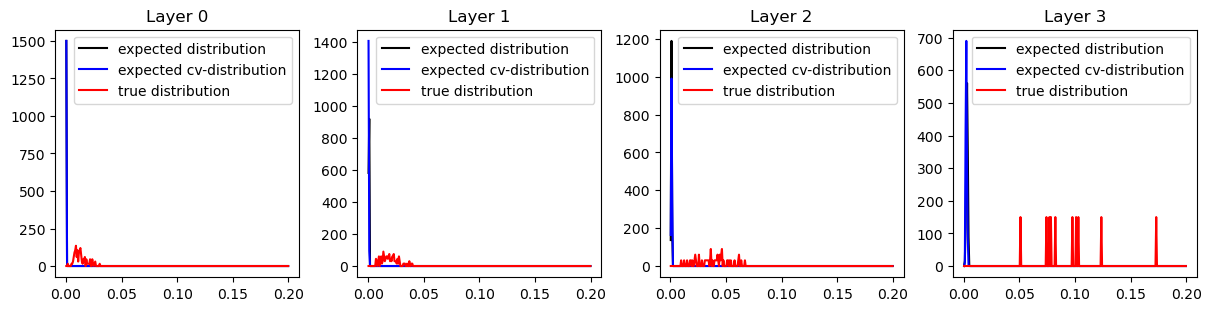

In [35]:
# max_bin = [torch.where(torch.any(cc>0, dim=0))[0][-1] for cc in cad]

num_layers = len(w)
figdim = 3
fig, ax = plt.subplots(1, num_layers, figsize=(num_layers*figdim, figdim), layout='constrained')
for layer in range(num_layers):
    ax[layer].plot(calign_centers, c_dist[layer], c='k', label='expected distribution')
    ax[layer].plot(calign_centers, cv_dist[layer], c='b', label='expected cv-distribution')
    ax[layer].plot(calign_centers, t_dist[layer], c='r', label='true distribution')
    # ax[layer].set_xscale('log')
    ax[layer].set_title(f"Layer {layer}")
    ax[layer].legend()
    
plt.show()

# I'd like to compare these cvPCA results to the observed alignment distribution
# to determine if the reason alignment and delta alignment is much higher than expected
# according to Ila Fiete is because of the batching implicitly "cross-validating" the 
# updates according to class-dependent structure rather than simply all structure. 

# In other words, if it is the case that the network primarily learns stimulus specific
# dimensions, rather than full data dimensions, it may be because any other dimensions
# are ignored by the batching. (And therefore implicitly prevents over-generalization!)

# Other experiment: Determine if these dimensions are overrepresented in the dataset. 

In [23]:
[torch.max(align) for align in c_alignment]

[tensor(0.0304, device='cuda:0'),
 tensor(0.0398, device='cuda:0'),
 tensor(0.0668, device='cuda:0'),
 tensor(0.1733, device='cuda:0')]

In [75]:
# Some Code for continual learning with permuted MNIST
from functools import partial

def permute(batch, batch_dim=True, shuffle_idx=None):
    if shuffle_idx is not None:
        original_size = batch[0].shape
        if batch_dim:
            batch[0] = batch[0][:, shuffle_idx]
        else:
            batch[0] = batch[0][shuffle_idx]
        batch[0].reshape(original_size)
    return batch

def add_permutation(dataset, num_pixels=784):
    perm = partial(permute, batch_dim=True, shuffle_idx=torch.randperm(num_pixels))
    if dataset.extra_transform is None:
        dataset.extra_transform = []
    dataset.extra_transform.append(perm)
    return dataset

def update_permutation(dataset, num_pixels=784):
    perm = partial(permute, batch_dim=True, shuffle_idx=torch.randperm(num_pixels))
    dataset.extra_transform[-1] = perm
    return dataset

def do_permuted_round(nets, optimizers, dataset, train_epochs=1, verbose=False):
    parameters = dict(
        verbose=verbose,
        num_epochs=train_epochs,
        alignment=False,
    )
    dataset = update_permutation(dataset)
    
    # train and test
    train_results = train.train(nets, optimizers, dataset, **parameters)
    test_results = train.test(nets, dataset, **parameters)

    return train_results, test_results

In [74]:
model_name = 'MLP'
dataset_name = 'MNIST'

net = get_model(model_name, build=True, dataset=dataset_name, dropout=0.0, ignore_flag=False)
net.to(DEVICE)

net_dropout = get_model(model_name, build=True, dataset=dataset_name, dropout=0.5, ignore_flag=False)
net_dropout.to(DEVICE)

loader_parameters = dict(
    shuffle=True,
)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, loader_parameters=loader_parameters, device=DEVICE)
dataset = add_permutation(dataset)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-5)
optimizer_dropout = torch.optim.Adam(net_dropout.parameters(), lr=1e-2, weight_decay=1e-5)

nets = [net, net_dropout]
optimizers = [optimizer, optimizer_dropout]


num_rounds = 100

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for round in tqdm(range(num_rounds)):
    c_train_res, c_test_res = do_permuted_round(nets, optimizers, dataset)
    train_loss.append(c_train_res['loss'])
    train_accuracy.append(c_train_res['accuracy'])
    test_loss.append(c_test_res['loss'])
    test_accuracy.append(c_test_res['accuracy'])
    print("Test Results on round:", round, "are:", c_test_res['loss'], c_test_res['accuracy'])

 33%|███▎      | 1/3 [00:07<00:14,  7.10s/it]

Test Results on round: 0 are: [0.18367412090301513, 0.32116109132766724] [94.39831771850587, 91.55532531738281]


 67%|██████▋   | 2/3 [00:10<00:05,  5.08s/it]

Test Results on round: 1 are: [0.184918574988842, 0.3605641096830368] [94.189453125, 90.62838821411133]


100%|██████████| 3/3 [00:14<00:00,  4.84s/it]

Test Results on round: 2 are: [0.20054687857627868, 0.598221355676651] [93.66509857177735, 83.60311660766601]


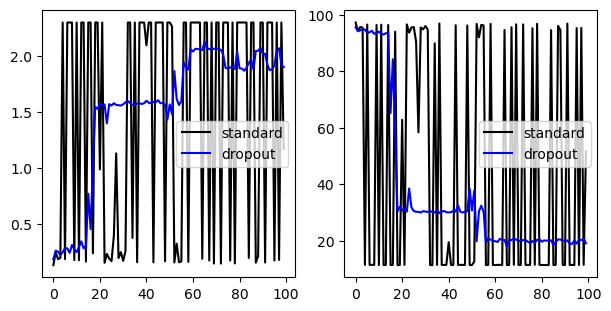

In [65]:
loss = torch.stack([torch.tensor(l) for l in test_loss])
accuracy = torch.stack([torch.tensor(a) for a in test_accuracy])

cols = 'kb'
names = ['standard', 'dropout']

fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout='constrained')
for ii in range(2):
    ax[0].plot(range(100), loss[:, ii], c=cols[ii], label=names[ii])
    ax[1].plot(range(100), accuracy[:, ii], c=cols[ii], label=names[ii])

ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()